In [156]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from scipy.io import loadmat
from pandas import DataFrame
import scipy.signal as spsig
from sklearn import preprocessing
import pandas as pd
import csv
from tqdm import tqdm
from scipy.stats import zscore
import eeglib
import tsfeatures as tf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

## Preproccess data

### Train

In [3]:
def proccess_train_data(pat):
    read_dir = 'data/Pat'+str(pat)+'Train'
    filenames = sorted(os.listdir(read_dir))
    train_filenames = []
    for filename in filenames:
        train_filenames.append(filename)
    n = len(train_filenames)
    image = loadmat(read_dir + '/' + train_filenames[0], squeeze_me=True)
    X = np.zeros(((n,) + image['data'].shape), dtype='float32')
    y = np.zeros(n, dtype='int8')

    filename_to_idx = {}
    for i, filename in enumerate(train_filenames):
        data= loadmat(read_dir + '/' + filename, squeeze_me=True)
        X[i] = zscore(data['data'])
        y[i] = 1 if filename.endswith('_1.mat') else 0
        filename_to_idx['Pat'+str(pat) + '/' + filename] = i
    
    return X, y

In [42]:
X, y = proccess_train_data(1)
print(X.shape)
print(y.shape)
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

(826, 240000, 16)
(826,)


{0: 570, 1: 256}

### Test

In [20]:
def proccess_test_data(pat):
    test_csv = pd.read_csv('data/contest_test_data_labels_public.csv')
    test_csv = test_csv[test_csv['usage'] == 'Public']
    test_csv = test_csv.drop(['usage'], axis = 1)
    test_labels = test_csv['class']

    pats = [1,2,3]
    for p in pats:
        if p != pat:
            test_csv = test_csv[test_csv["image"].str.contains('Pat'+str(p)) == False]

            
    test_n = test_csv.shape[0]
    read_dir = 'data/Pat'+str(pat)+'Test'
    x_test = np.zeros(((test_n,) + (240000, 16)), dtype='float32')
    y_test = np.zeros(test_n, dtype='int8')
    filename_to_idx_test = {}
    idx = 0
    for index, row in test_csv.iterrows():
        datum = loadmat(read_dir + '/' + row['image'], squeeze_me=True)
        x_test[idx] = datum['data']
        y_test[idx] = row['class']
        filename_to_idx_test['Pat'+ str(pat) + '/' + row['image']] = index
        idx += 1
    
    return x_test, y_test

In [185]:
test_X, test_y = proccess_test_data(1)
print(test_X.shape)
print(test_y.shape)
unique, counts = np.unique(test_y, return_counts=True)
dict(zip(unique, counts))

(61, 240000, 16)
(61,)


{0: 45, 1: 16}

## Feature Extraction

### Feature graphs

In [172]:
bands={'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'low-gamma': (30,47), 'hig-gamma':(53,120)}

eeg_data = eeglib.eeg.EEG(240000, 400, 16)
eeg_data.set(X[0])
b_pwr = eeg_data.bandPower(bands=bands)
data_full = np.zeros((16,6), dtype='float32')
idx = 0
for i in b_pwr:
    data_full[idx] = list(i.values())
    idx += 1

data_full = data_full.astype(float)
data = preprocessing.scale(data_full, axis=1,with_std=True)

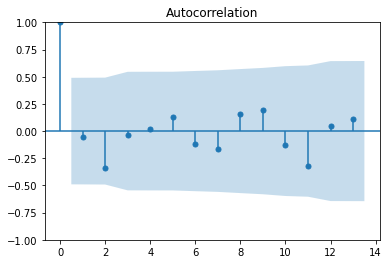

In [173]:
sm.graphics.tsa.plot_acf(data.T[0], lags=13)
plt.show()

In [179]:
for i in data.T:
    ar = acf(i, qstat=True)
    tsf_acf = tf.acf_features(i)

print(tsf_acf)
for i in ar:
    print(i[1])


{'x_acf1': 0.39606803503504345, 'x_acf10': 0.48782665230560424, 'diff1_acf1': -0.2963474684036706, 'diff1_acf10': 0.13502337290733743, 'diff2_acf1': -0.5823523991345141, 'diff2_acf10': 0.38911081601561276}
0.39606803503504356
3.5752196629319677
0.16735970990505397


3.5752196629319677

### Extraction Method

In [181]:
def feature_extraction_csv(pat,type,X,y):
    outfile = 'pat_'+str(pat)+'_feature_bands_'+type+'.csv'
    mydata = []

    # band (0.1 - 4 ; 4- 8 ; 8 - 15 ; 15 - 30 ; 30 - 90 ; 90 - 170 Hz
    bands={'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30), 'low-gamma': (30,47), 'hig-gamma':(53,120)}
    for idx, x in tqdm(enumerate(X)):
        eeg_data = eeglib.eeg.EEG(240000, 400, 16)
        eeg_data.set(x)
        b_pwr = eeg_data.bandPower(bands=bands)
        data_full = np.zeros((16,6), dtype='float32')
        ind = 0
        for i in b_pwr:
            data_full[ind] = list(i.values())
            ind += 1

        output = []
        featureList = []
        featureList.append('Label')
        output.append(y[idx])
        featureList.append('Pat')
        output.append(pat)
        data_full = data_full.astype(float)
        data = preprocessing.scale(data_full, axis=1,with_std=True)

        ### FEATURE 1 - CORRELATION COEF (count - 120)
        h=np.corrcoef(data)
        h=np.nan_to_num(h)
        ind = np.triu_indices(16, 1)
        htri = h[ind]
        for ii in range(np.size(htri)):
                featureList.append('coef%i'%(ii))
                output.append(htri[ii])

        ### FEATURE 2 - AR 1 and sum of 10 coef (count - 6 (1 per band))
        for band, i in enumerate(data.T):
            tsf_acf = tf.acf_features(i)
            featureList.append('AR%i'%(band))
            output.append(tsf_acf['x_acf1'])
            featureList.append('AR_10%i'%(band))
            output.append(tsf_acf['x_acf10'])

        
        ### FEATURE 3 - AR LB q (count - 6 (1 per band))
        for band, i in enumerate(data.T):
            ar = acf(i, qstat=True)
            featureList.append('AR_q%i'%(band))
            output.append(ar[1][1])

        mydata.append(pd.DataFrame({'Features':output},index=featureList).T)

    trainSample = pd.concat(mydata,ignore_index=True)
    trainSample.to_csv(outfile)

In [186]:
feature_extraction_csv(1,'train', X, y)
feature_extraction_csv(1,'test', test_X, test_y)

61it [00:20,  3.01it/s]


### Feature cleaning

In [187]:
features_train = pd.read_csv('pat_1_feature_bands_train.csv')
features_test = pd.read_csv('pat_1_feature_bands_test.csv')

In [188]:
print(features_train.shape)
print(features_test.shape)
print("Number of features:",features_test.shape[1]-3)

(826, 141)
(61, 141)
Number of features: 138


In [189]:
features_train.dropna(thresh=features_train.shape[1]-3, inplace=True)
features_train.replace([np.inf, -np.inf], np.nan, inplace=True)
features_train.fillna(0, inplace=True)

features_test.dropna(thresh=features_test.shape[1]-3, inplace=True)
features_test.replace([np.inf, -np.inf], np.nan, inplace=True)
features_test.fillna(0, inplace=True)

In [190]:
label_train = features_train.Label.values
label_test = features_test.Label.values
x_train = features_train.drop(['Label', 'Pat', 'Unnamed: 0'], axis=1)
x_test= features_test.drop(['Label', 'Pat', 'Unnamed: 0'], axis=1)

## Model

In [191]:
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier


### XGB

In [209]:
params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": 0.01,
        "max_depth": 5,
        "subsample": 0.5,
        "colsample_bytree": 0.5,
        "num_parallel_tree": 2,
    }

# params = {
#     'objective':"binary:logistic", 
#     'booster'             : "gbtree",
#     'eval_metric'         : "auc",
#     'eta'                 : 0.3,
#     'max_depth'           : 3,
#     'subsample'           : 0.5,
#     'colsample_bytree'    : 1,
#     'num_parallel_tree'   : 2
# }

dtrain=xgb.DMatrix(x_train,label_train)
model=xgb.train(params,dtrain,num_boost_round=500,verbose_eval=20)

test=xgb.DMatrix(x_test)
y_pred = model.predict(test)
auc = metrics.roc_auc_score(label_test, y_pred)
print ("AUC: " + str(auc)) 

AUC: 0.4486111111111111


<AxesSubplot:>

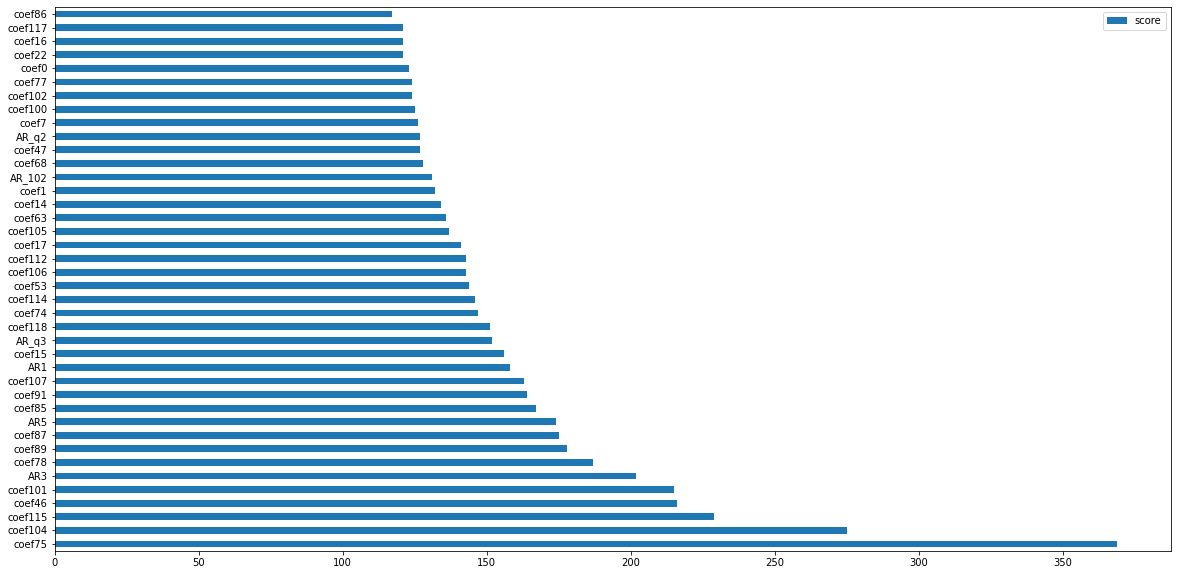

In [210]:
feature_important = model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

### ExtraTree

In [194]:
clf = ExtraTreesClassifier(n_estimators=4000, random_state=0, max_depth=11, n_jobs=2, criterion='entropy')
clf.fit(x_train,label_train)
y_pred = clf.predict_proba(x_test)

auc = metrics.roc_auc_score(label_test, y_pred[:,1])
print ("AUC: " + str(auc))

AUC: 0.5930555555555554


0.5736111111111111

### KNN

In [195]:
knn = KNeighborsClassifier(n_neighbors=40, weights='distance',metric='manhattan', n_jobs=-1)
knn.fit(x_train,label_train)
y_pred = knn.predict_proba(x_test)

auc = metrics.roc_auc_score(label_test, y_pred[:,1])
print ("AUC: " + str(auc))


AUC: 0.6569444444444444


0.6041666666666667